In [5]:
import os
import argparse
import logging
import time
import numpy as np
import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [6]:
args = {'adjoint' : False,
        'tol' : 1e-3,
        'lr' : 0.1,
        'save' : './exp_res_2',
        'gpu' : 0,
        'network' : 'odenet', 
        'adjoint' : False,
        'downsampling_method' : 'res', 
        'nepochs' : 20, 
        'data_aug' : True,
        'batch_size' : 128,
        'test_batch_size' : 1000,
        }

In [7]:
if args['adjoint']:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut


class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
#             dim_in, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
#         return self._layer.forward(x)
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1) # add time integration to X
        return self._layer(ttx)


class ODEfunc(nn.Module): # should be rewrite to NODE (KL)

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out
    
class ODEfunc2(nn.Module): # should be rewrite to NODE (KL)

    def __init__(self, dim):
        super(ODEfunc2, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
#         self.conv2 = ConcatConv2d(dim, dim // 2, 3, 1, 1)
        self.norm3 = norm(dim)
#         self.conv3 = ConcatConv2d(dim, dim * 2, 3, 1, 1)
        self.nfe = 0

    def forward(self, t, x): # differnce with ODEfunc1 forward
        self.nfe += 1
#         out = self.norm1(x)
#         out = self.relu(out)
#         out = self.conv1(t, out)
#         out = self.norm2(out)
#         out = self.relu(out)
#         out = self.conv2(t, out)
#         out = self.norm3(out)
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.conv1(t, out)
        out = self.conv1(t, out)
        out = self.relu(out)
        out = self.norm1(out)
        out = self.conv1(t, out)
        out = self.conv1(t, out)
        out = self.relu(out)
        out = self.norm1(out)
        
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=args['tol'], atol=args['tol']) # NODE usage
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


In [8]:
def get_mnist_loaders(data_aug=False, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(28, padding=4),
            transforms.ToTensor(),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


def learning_rate_with_decay(batch_size, batch_denom, batches_per_epoch, boundary_epochs, decay_rates):
    initial_learning_rate = args['lr'] * batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def get_logger(logpath, filepath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    logger.info(filepath)
    with open(filepath, "r") as f:
        logger.info(f.read())

    for f in package_files:
        logger.info(f)
        with open(f, "r") as package_f:
            logger.info(package_f.read())

    return logger


In [32]:

if __name__ == '__main__':
    makedirs(args['save'])
#     logger = get_logger(logpath=os.path.join(args['save'], 'logs'), filepath=os.path.abspath(__file__))
    logger = logging.getLogger()
    logger.info(args)

    device = torch.device('cuda:' + str(args['gpu']) if torch.cuda.is_available() else 'cpu')

    is_odenet = args['network'] == 'odenet'

    if args['downsampling_method'] == 'conv':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]
    elif args['downsampling_method'] == 'res':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]

    feature_layers = [ODEBlock(ODEfunc2(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
    fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

    model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

    logger.info(model)
    logger.info('Number of parameters: {}'.format(count_parameters(model)))

    criterion = nn.CrossEntropyLoss().to(device)

    train_loader, test_loader, train_eval_loader = get_mnist_loaders(
        args['data_aug'], args['batch_size'], args['test_batch_size']
    )

    data_gen = inf_generator(train_loader)
    batches_per_epoch = int(len(train_loader) / 15)

    lr_fn = learning_rate_with_decay(
        args['batch_size'], batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[60, 100, 140],
        decay_rates=[1, 0.1, 0.01, 0.001]
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9)

    best_acc = 0
    batch_time_meter = RunningAverageMeter()
    f_nfe_meter = RunningAverageMeter()
    b_nfe_meter = RunningAverageMeter()
    end = time.time()

    epochs_res = []
    time_work_res = []
    NFEf_res = []
    NFEb_res = []
    train_accs_res = []
    test_accs_res = []
    for itr in tqdm.tqdm(range(args['nepochs'] * batches_per_epoch)):

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_fn(itr)

        optimizer.zero_grad()
        x, y = data_gen.__next__()
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        if is_odenet:
            nfe_forward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        loss.backward()
        optimizer.step()

        if is_odenet:
            nfe_backward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        batch_time_meter.update(time.time() - end)
        if is_odenet:
            f_nfe_meter.update(nfe_forward)
            b_nfe_meter.update(nfe_backward)
        end = time.time()

        
        
        if itr % batches_per_epoch == 0:
            with torch.no_grad():
                train_acc = accuracy(model, train_eval_loader)
                val_acc = accuracy(model, test_loader)
                if val_acc > best_acc:
                    torch.save(model.state_dict(), os.path.join(args['save'], 'model.pt'))
                    best_acc = val_acc
                logger.info(
                    "Epoch {:04d} | Time {:.3f} ({:.3f}) | NFE-F {:.1f} | NFE-B {:.1f} | "
                    "Train Acc {:.4f} | Test Acc {:.4f}".format(
                        itr // batches_per_epoch, batch_time_meter.val, batch_time_meter.avg, f_nfe_meter.avg,
                        b_nfe_meter.avg, train_acc, val_acc
                    )
                )
                print("Epoch {:04d} | Time {:.3f} ({:.3f}) | NFE-F {:.1f} | NFE-B {:.1f} | "
                    "Train Acc {:.4f} | Test Acc {:.4f}".format(
                        itr // batches_per_epoch, batch_time_meter.val, batch_time_meter.avg, f_nfe_meter.avg,
                        b_nfe_meter.avg, train_acc, val_acc
                    )
                )
                epochs_res.append(itr // batches_per_epoch)
                time_work_res.append(batch_time_meter.val)
                NFEf_res.append(f_nfe_meter.avg)
                NFEb_res.append(b_nfe_meter.avg)
                train_accs_res.append(train_acc)
                test_accs_res.append(val_acc)
#             test_model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
#             test_model.load_state_dict(torch.load(os.path.join(args['save'], 'model.pt')))
                                                  

  0%|                                                                            | 1/620 [20:07<207:32:57, 1207.07s/it]

Epoch 0000 | Time 6.412 (6.412) | NFE-F 32.0 | NFE-B 0.0 | Train Acc 0.0992 | Test Acc 0.1010


  5%|███▉                                                                         | 32/620 [34:32<36:04:44, 220.89s/it]

Epoch 0001 | Time 3.813 (14.796) | NFE-F 46.4 | NFE-B 0.0 | Train Acc 0.1157 | Test Acc 0.1157


 10%|███████▊                                                                     | 63/620 [48:40<34:31:46, 223.17s/it]

Epoch 0002 | Time 3.861 (17.188) | NFE-F 49.7 | NFE-B 0.0 | Train Acc 0.5796 | Test Acc 0.5861


 15%|███████████▎                                                               | 94/620 [1:05:04<37:20:33, 255.58s/it]

Epoch 0003 | Time 4.423 (19.275) | NFE-F 52.1 | NFE-B 0.0 | Train Acc 0.5991 | Test Acc 0.5932


 20%|██████████████▉                                                           | 125/620 [1:21:30<35:30:50, 258.28s/it]

Epoch 0004 | Time 4.427 (21.504) | NFE-F 53.8 | NFE-B 0.0 | Train Acc 0.7526 | Test Acc 0.7514


 25%|██████████████████▌                                                       | 156/620 [1:38:34<34:26:57, 267.28s/it]

Epoch 0005 | Time 4.828 (23.293) | NFE-F 55.1 | NFE-B 0.0 | Train Acc 0.7683 | Test Acc 0.7761


 30%|██████████████████████▎                                                   | 187/620 [1:55:06<30:53:58, 256.90s/it]

Epoch 0006 | Time 4.728 (24.846) | NFE-F 56.1 | NFE-B 0.0 | Train Acc 0.8813 | Test Acc 0.8827


 35%|██████████████████████████                                                | 218/620 [2:10:56<27:37:34, 247.40s/it]

Epoch 0007 | Time 4.477 (25.615) | NFE-F 56.9 | NFE-B 0.0 | Train Acc 0.9339 | Test Acc 0.9381


 40%|█████████████████████████████▋                                            | 249/620 [2:26:33<25:06:09, 243.58s/it]

Epoch 0008 | Time 4.458 (25.959) | NFE-F 57.4 | NFE-B 0.0 | Train Acc 0.9237 | Test Acc 0.9294


 45%|█████████████████████████████████▍                                        | 280/620 [2:40:07<20:10:26, 213.61s/it]

Epoch 0009 | Time 3.587 (25.888) | NFE-F 58.0 | NFE-B 0.0 | Train Acc 0.9536 | Test Acc 0.9612


 50%|█████████████████████████████████████                                     | 311/620 [2:53:34<18:10:03, 211.66s/it]

Epoch 0010 | Time 3.774 (25.119) | NFE-F 58.2 | NFE-B 0.0 | Train Acc 0.9497 | Test Acc 0.9550


 55%|████████████████████████████████████████▊                                 | 342/620 [3:07:03<16:21:05, 211.75s/it]

Epoch 0011 | Time 3.638 (24.519) | NFE-F 58.4 | NFE-B 0.0 | Train Acc 0.9431 | Test Acc 0.9522


 60%|████████████████████████████████████████████▌                             | 373/620 [3:20:30<14:30:15, 211.40s/it]

Epoch 0012 | Time 3.583 (24.077) | NFE-F 58.5 | NFE-B 0.0 | Train Acc 0.9612 | Test Acc 0.9674


 65%|████████████████████████████████████████████████▏                         | 404/620 [3:34:08<12:51:43, 214.37s/it]

Epoch 0013 | Time 3.658 (23.749) | NFE-F 58.7 | NFE-B 0.0 | Train Acc 0.9445 | Test Acc 0.9479


 70%|███████████████████████████████████████████████████▉                      | 435/620 [3:47:51<11:08:00, 216.65s/it]

Epoch 0014 | Time 3.771 (23.568) | NFE-F 58.8 | NFE-B 0.0 | Train Acc 0.9732 | Test Acc 0.9765


 75%|████████████████████████████████████████████████████████▎                  | 466/620 [4:02:03<9:37:07, 224.86s/it]

Epoch 0015 | Time 3.610 (23.494) | NFE-F 59.0 | NFE-B 0.0 | Train Acc 0.9700 | Test Acc 0.9740


 80%|████████████████████████████████████████████████████████████               | 497/620 [4:16:42<7:48:37, 228.60s/it]

Epoch 0016 | Time 3.690 (23.778) | NFE-F 59.0 | NFE-B 0.0 | Train Acc 0.9540 | Test Acc 0.9559


 85%|███████████████████████████████████████████████████████████████▊           | 528/620 [4:30:36<5:33:52, 217.74s/it]

Epoch 0017 | Time 3.778 (24.001) | NFE-F 58.9 | NFE-B 0.0 | Train Acc 0.9653 | Test Acc 0.9697


 90%|███████████████████████████████████████████████████████████████████▌       | 559/620 [4:44:07<3:35:43, 212.19s/it]

Epoch 0018 | Time 3.654 (23.850) | NFE-F 58.8 | NFE-B 0.0 | Train Acc 0.9787 | Test Acc 0.9827


 95%|███████████████████████████████████████████████████████████████████████▎   | 590/620 [4:57:43<1:47:11, 214.37s/it]

Epoch 0019 | Time 3.751 (23.594) | NFE-F 58.9 | NFE-B 0.0 | Train Acc 0.9716 | Test Acc 0.9727


100%|██████████████████████████████████████████████████████████████████████████████| 620/620 [4:59:36<00:00, 28.99s/it]


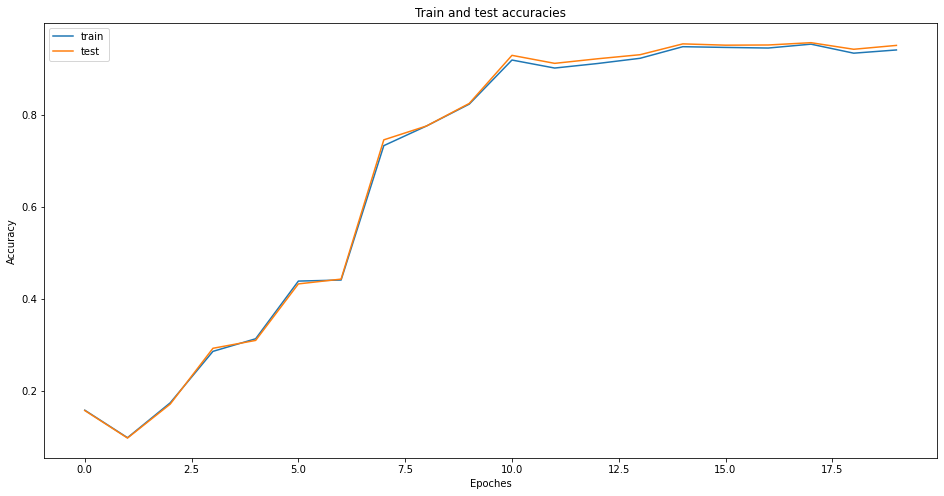

In [5]:
epoches = range(20)
train_accs = [0.1585 ,0.0987, 0.1745 , 0.2863, 0.3137, 0.4390 , 0.4413, 0.7333 , 0.7760, 0.8235 , 0.9193, 0.9019, 0.9117, 0.9231, 0.9483 , 0.9467, 0.9454, 0.9538, 0.9342 , 0.9412 ]
test_accs = [0.1578,0.0980, 0.1717, 0.2930, 0.3101, 0.4329, 0.4433, 0.7459, 0.7760, 0.8250, 0.9295, 0.9121, 0.9220, 0.9309, 0.9544, 0.9516, 0.9520, 0.9570, 0.9427, 0.9511 ]
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
plt.title("Train and test accuracies")
plt.xlabel('Epoches')
plt.ylabel("Accuracy")
plt.plot(epoches, train_accs, label = "train")
plt.plot(epoches, test_accs, label = "test")
plt.legend()


In [20]:
print("Best test accuracy on Conv version:", max(test_accs))

Best test accuracy on Conv version: 0.957


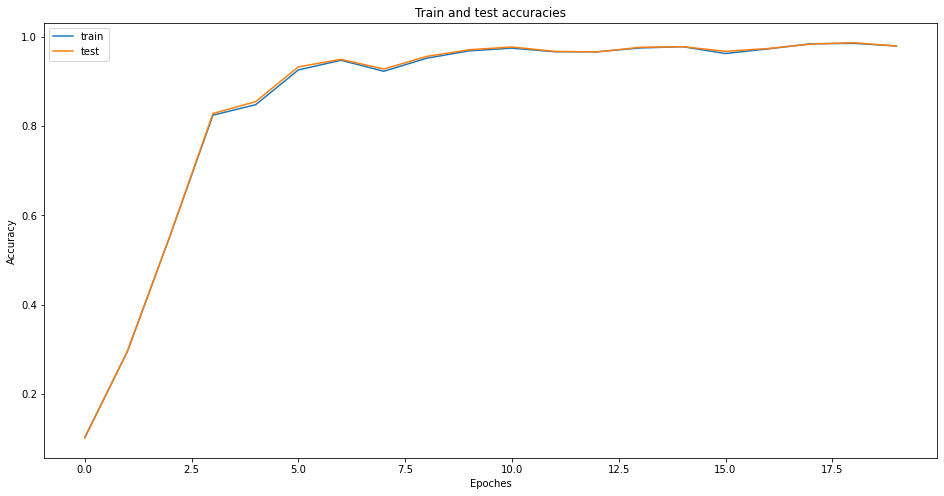

In [21]:
train_accs_res_1 = [0.1022 , 0.2955 , 0.5553 ,0.8244 , 0.8479 , 0.9257 , 0.9474 ,0.9227 , 0.9519,0.9686 ,0.9745 , 0.9665 ,0.9665, 0.9750 , 0.9778 ,0.9625 , 0.9730 , 0.9843 , 0.9853 , 0.9794   ]
test_accs_res_1 = [0.1010, 0.2959,0.5552,0.8281, 0.8547,0.9327,0.9494, 0.9278,0.9560, 0.9710, 0.9772,0.9673,0.9661,0.9765,0.9778,  0.9675,0.9738,0.9837,0.9837,0.9868,0.9793 ]
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
plt.title("Train and test accuracies")
plt.xlabel('Epoches')
plt.ylabel("Accuracy")
plt.plot(epoches, train_accs_res_1, label = "train")
plt.plot(epoches, test_accs_res_1, label = "test")
plt.legend()



In [23]:

print("Best test accuracy on RNN:", max(test_accs_res))

Best test accuracy on RNN: 0.9868


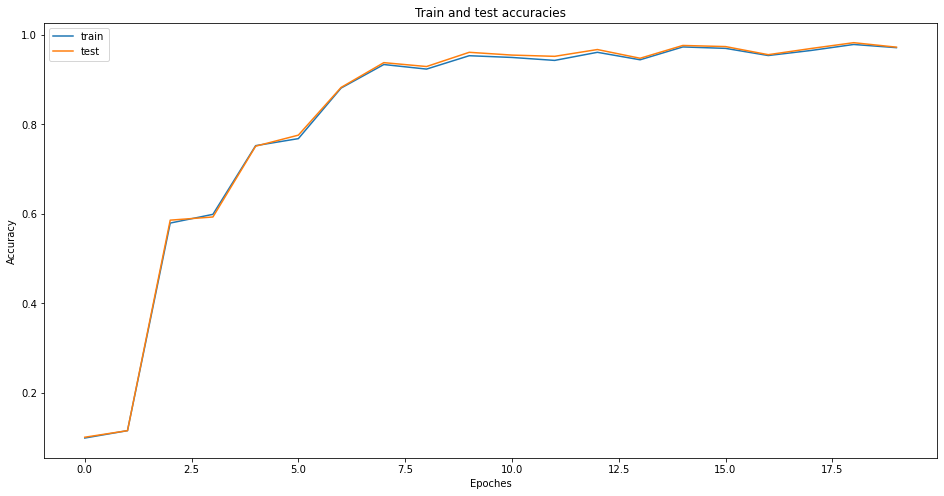

In [2]:
epoches = range(20)
train_accs_res = [0.0992 , 0.1157 , 0.5796 , 0.5991 , 0.7526 , 0.7683 ,0.8813 ,0.9339 ,0.9237 ,0.9536 , 0.9497 ,0.9431 , 0.9612 , 0.9445 ,0.9732 , 0.9700 ,0.9540 ,0.9653,0.9787 ,0.9716 ]
test_accs_res = [0.1010, 0.1157, 0.5861, 0.5932, 0.7514, 0.7761, 0.8827,0.9381,0.9294,0.9612,0.9550, 0.9522,0.9674,0.9479,0.9765,0.9740,0.9559,0.9697,0.9827,0.9727]
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
plt.title("Train and test accuracies")
plt.xlabel('Epoches')
plt.ylabel("Accuracy")
plt.plot(epoches, train_accs_res, label = "train")
plt.plot(epoches, test_accs_res, label = "test")
plt.legend()


In [3]:
print("BEST TEST ACCURACY ON RES-FUNC2:", max(test_accs_res))

BEST TEST ACCURACY ON RES-FUNC2: 0.9827


In [10]:
is_odenet = args['network'] == 'odenet'
device = torch.device('cuda:' + str(args['gpu']) if torch.cuda.is_available() else 'cpu')
if args['downsampling_method'] == 'res':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]

feature_layers = [ODEBlock(ODEfunc2(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

print(model)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (2): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (3): ODEBlock(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05,